This notebook compares the three R&S based methods on LCEGP.
The three methods are KG, TS, and lookahead PCS.

In [3]:
from time import time

import torch
from botorch import fit_gpytorch_model
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils import draw_sobol_normal_samples
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

from contextual_rs.lce_gp import LCEGP
from contextual_rs.unknown_correlation_model import UnknownCorrelationModel
from contextual_rs.pcs_no_context import estimate_lookahead_pcs_no_context
from contextual_rs.rs_kg import DiscreteKG
from contextual_rs.custom_fit import custom_fit_gpytorch_model
from contextual_rs.rs_kg_w_s_tilde import find_kg_maximizer

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


def model_constructor(model_type: str):
    def model_create(X, Y, custom_fit=0):
        if model_type == "LCEGP":
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[2]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            if custom_fit:
                custom_fit_gpytorch_model(mll, num_retries=custom_fit)
            else:
                fit_gpytorch_model(mll)
            return model
        else:
            model = UnknownCorrelationModel(X, Y, update_method=model_type)
            return model
    return model_create


def pcs_run(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    replications: int,
    num_samples: int = 100,
    func_I = lambda X: (X > 0).to(dtype=torch.float),
    num_fantasies: int = 16,
    custom_fit: int = 0,
    fit_frequency = 1,  # set > 1 if we don't want to fit LCEMGP at each iteration.
    device: str = "cpu",
    dtype: torch.dtype = torch.float,
    use_s_tilde: bool = False,
) -> None:
    ckwargs = {"device": device, "dtype": dtype}
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K, **ckwargs)
    true_cov = torch.zeros(K, K, **ckwargs)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho, **ckwargs).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    train_X = torch.arange(
        num_alternatives, **ckwargs
    ).repeat(num_full_train)
    train_Y = sampling_post.rsample(torch.Size([num_full_train])).view(-1).detach()

    labels = ["KG", "TS", "PCS"]

    constructor = model_constructor("LCEGP")

    base_samples = draw_sobol_normal_samples(
        d=num_alternatives, n=num_samples
    ).reshape(num_samples, 1, 1, num_alternatives, 1).to(**ckwargs)

    all_alternatives = torch.arange(
        num_alternatives, **ckwargs
    ).view(-1, 1, 1)

    predicted_bests = [torch.zeros(replications, iterations, **ckwargs) for _ in range(3)]
    start = time()
    for rep in range(replications):
        X_list = [train_X.clone() for _ in range(3)]
        Y_list = [train_Y.clone() for _ in range(3)]
        old_models = [None] * 3
        for i in range(iterations):
            if i == 0:
                print(f"Starting replication {rep}, iteration {i}, time: {time()-start}")
            next_points = torch.zeros(3, **ckwargs)
            for j in range(3):
                if fit_frequency > 1 and i % fit_frequency != 0:
                    # in this case, we will not re-train LCEGP.
                    # we will just condition on observations.
                    model = old_models[j].condition_on_observations(
                        X=X_list[j][-1].view(-1, 1),
                        Y=Y_list[j][-1].view(-1, 1),
                    )
                else:
                    model = constructor(X_list[j], Y_list[j], custom_fit)
                predicted_bests[j][rep, i] = model.posterior(all_alternatives).mean.argmax()
                old_models[j] = model
                if j == 0:
                    # KG
                    if use_s_tilde:
                        next_sample = torch.tensor(
                            find_kg_maximizer(model)
                        )
                    else:
                        kg = DiscreteKG(
                            model=model, num_fantasies=num_fantasies,
                        )
                        kg_vals = kg(all_alternatives)
                        next_sample = kg_vals.argmax()
                elif j == 1:
                    # TS
                    posterior_samples = model.posterior(
                        all_alternatives.squeeze(-2)
                    ).rsample(
                        sample_shape=torch.Size([1])
                    ).detach()
                    next_sample = posterior_samples.argmax(dim=-2).squeeze()
                else:
                    # PCS
                    lookahead_pcs_vals = estimate_lookahead_pcs_no_context(
                        candidate=all_alternatives,
                        model=model,
                        model_sampler=SobolQMCNormalSampler(num_fantasies),
                        arm_set=all_alternatives.squeeze(-2),
                        num_samples=num_samples,
                        base_samples=base_samples,
                        func_I=func_I,
                    )
                    next_sample = lookahead_pcs_vals.argmax()

                next_points[j] = next_sample.to(**ckwargs).view(-1)

            full_eval = sampling_post.rsample().view(-1).detach()
            next_evals = full_eval[next_points.long()]

            for j in range(3):
                X_list[j] = torch.cat([X_list[j], next_points[j].view(-1)], dim=-1)
                Y_list[j] = torch.cat([Y_list[j], next_evals[j].view(-1)], dim=-1)

    plot_values = [
        sampling_post.mean[tmp.long()].detach().mean(dim=0).cpu()
        for tmp in predicted_bests
    ]
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')

    for i in range(3):
        plt.plot(plot_values[i], label=labels[i])
    plt.axhline(sampling_post.mean.max(), label="true_best")
    plt.grid()
    plt.legend()
    plt.show()


# debug run
# pcs_run(
#     num_alternatives=5,
#     rho=0.5,
#     num_full_train=5,
#     iterations=5,
#     replications=1,
# )

Starting replication 0, iteration 0, time: 6.604194641113281e-05
Starting replication 1, iteration 0, time: 47.4251389503479
Starting replication 2, iteration 0, time: 104.41242742538452
Starting replication 3, iteration 0, time: 153.51450443267822
Starting replication 4, iteration 0, time: 214.16829919815063


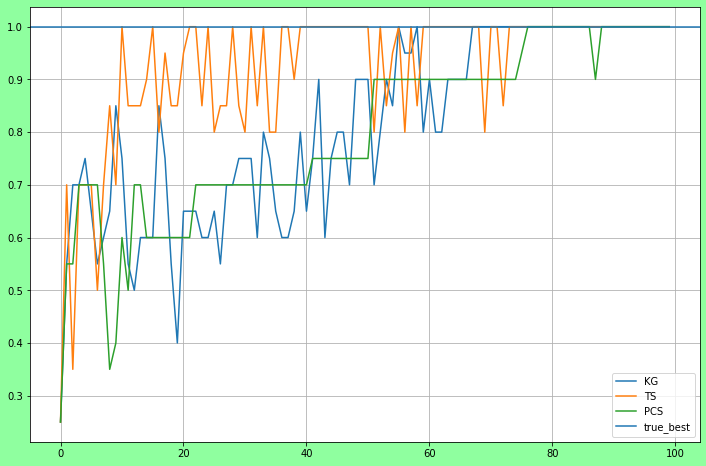

In [8]:
pcs_run(
    num_alternatives=5,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
)


Starting replication 0, iteration 0, time: 7.82012939453125e-05
Starting replication 1, iteration 0, time: 144.92223381996155
Starting replication 2, iteration 0, time: 283.8565561771393
Starting replication 3, iteration 0, time: 394.6998870372772
Starting replication 4, iteration 0, time: 520.5316898822784


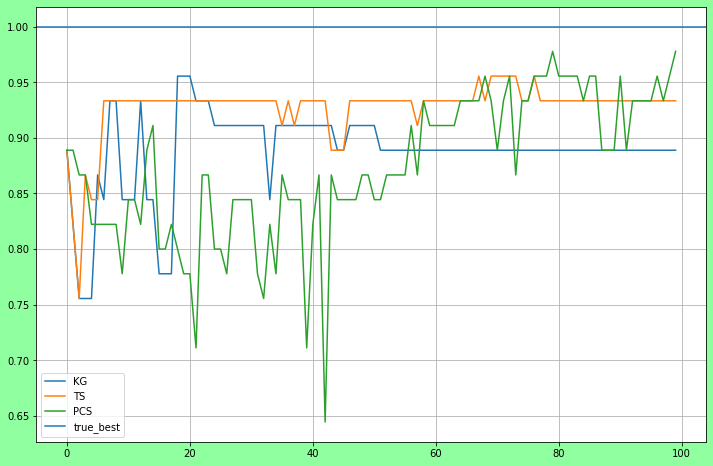

In [9]:
pcs_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 6.699562072753906e-05
Starting replication 1, iteration 0, time: 418.49565172195435
Starting replication 2, iteration 0, time: 819.3239061832428
Starting replication 3, iteration 0, time: 1219.520555973053
Starting replication 4, iteration 0, time: 1654.5748510360718
Starting replication 5, iteration 0, time: 2076.0490729808807
Starting replication 6, iteration 0, time: 2488.100517988205
Starting replication 7, iteration 0, time: 2894.857020378113
Starting replication 8, iteration 0, time: 3337.6607172489166
Starting replication 9, iteration 0, time: 3790.714203596115


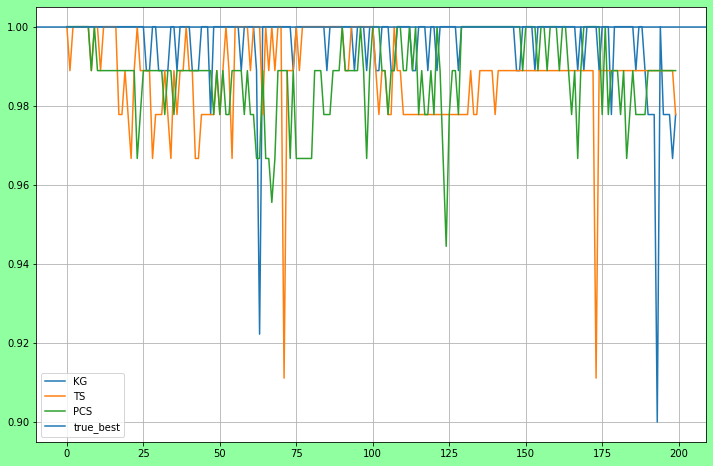

In [10]:
pcs_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=200,
    replications=10,
)

Starting replication 0, iteration 0, time: 6.818771362304688e-05
Starting replication 1, iteration 0, time: 420.3753798007965
Starting replication 2, iteration 0, time: 836.6332969665527
Starting replication 3, iteration 0, time: 1264.6668021678925
Starting replication 4, iteration 0, time: 1692.5203022956848


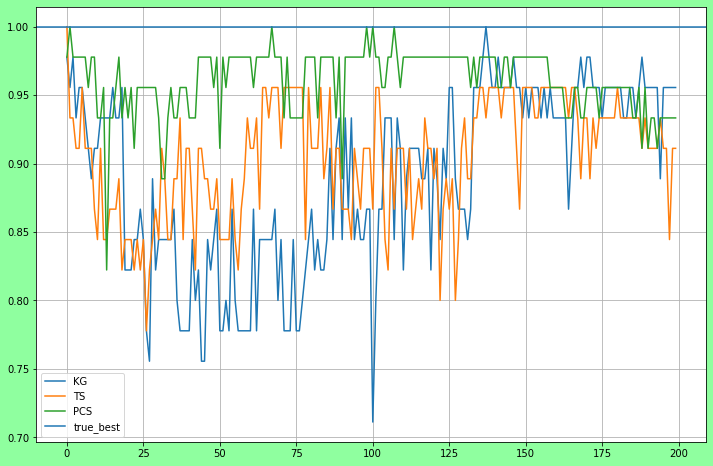

In [4]:
pcs_run(
    num_alternatives=10,
    rho=0.7,
    num_full_train=5,
    iterations=200,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.075599670410156e-05
Starting replication 1, iteration 0, time: 190.87448120117188
Starting replication 2, iteration 0, time: 393.4950897693634
Starting replication 3, iteration 0, time: 575.7939801216125
Starting replication 4, iteration 0, time: 748.0910220146179


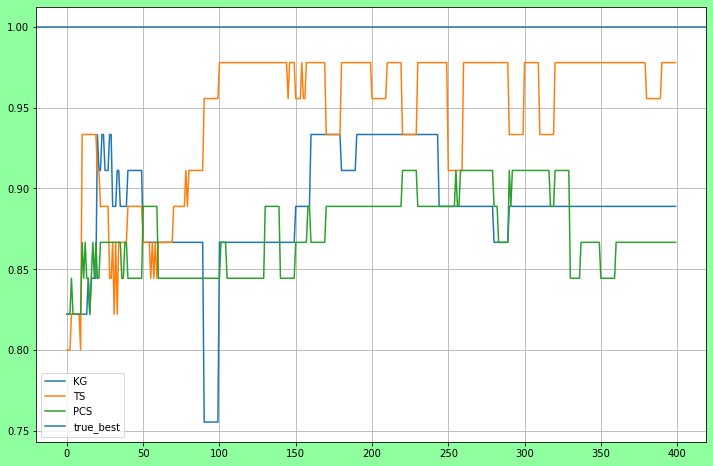

In [7]:
pcs_run(
    num_alternatives=10,
    rho=0.8,
    num_full_train=5,
    iterations=400,
    replications=5,
    fit_frequency=10,
    use_s_tilde=True,
)

Starting replication 0, iteration 0, time: 7.200241088867188e-05
Starting replication 1, iteration 0, time: 295.17844223976135
Starting replication 2, iteration 0, time: 611.6789102554321
Starting replication 3, iteration 0, time: 908.7151892185211
Starting replication 4, iteration 0, time: 1224.613606452942


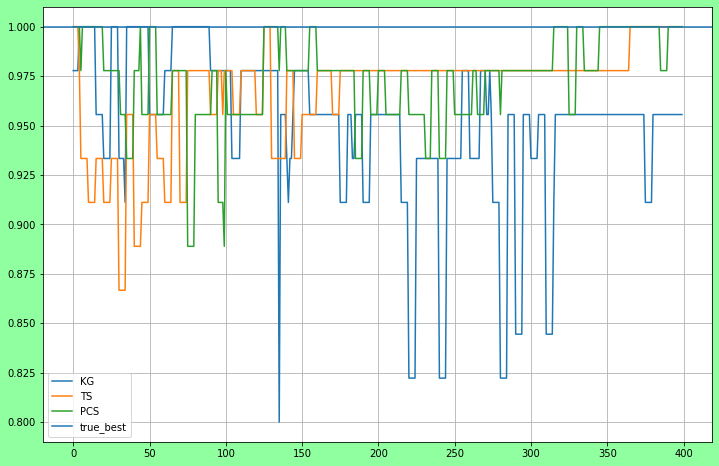

In [8]:
pcs_run(
    num_alternatives=10,
    rho=0.8,
    num_full_train=5,
    iterations=400,
    replications=5,
    fit_frequency=5,
    use_s_tilde=True,
)

Starting replication 0, iteration 0, time: 3.886222839355469e-05
Starting replication 1, iteration 0, time: 98.16744637489319
Starting replication 2, iteration 0, time: 206.98874306678772
Starting replication 3, iteration 0, time: 306.3960134983063
Starting replication 4, iteration 0, time: 407.22882556915283
Starting replication 5, iteration 0, time: 503.9235210418701
Starting replication 6, iteration 0, time: 607.0682468414307
Starting replication 7, iteration 0, time: 709.7940142154694
Starting replication 8, iteration 0, time: 824.3959515094757
Starting replication 9, iteration 0, time: 943.7698299884796


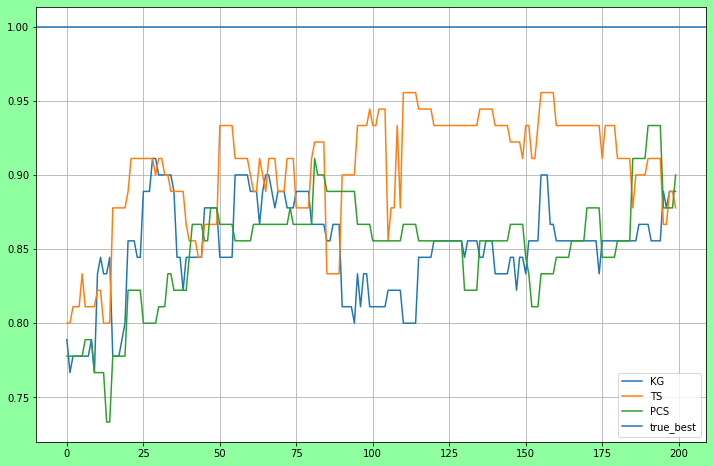

In [10]:
pcs_run(
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=200,
    replications=10,
    fit_frequency=5,
    use_s_tilde=True,
)